##Loading the UrbanSound8K Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Downloading UrbanSound8K Dataset

In [2]:
import os
dataset_path = "/content/drive/MyDrive/UrbanSound8K"
os.makedirs(dataset_path, exist_ok=True)


In [ ]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O /content/drive/MyDrive/UrbanSound8K/UrbanSound8K.tar.gz
!tar -xzf /content/drive/MyDrive/UrbanSound8K/UrbanSound8K.tar.gz -C /content/drive/MyDrive/


--2025-11-18 01:45:13--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-11-18 01:45:13--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/UrbanSound8K/UrbanSound8K.tar.gz’

gz                    0%[                    ]  35.81M   537KB/s    eta 1h 59m ^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [3]:
%cd /content/drive/MyDrive/UrbanSound8K


/content/drive/MyDrive/UrbanSound8K


In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [5]:
import pandas as pd
base_dir = "/content/drive/MyDrive/UrbanSound8K"
metadata_path = f"{base_dir}/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
metadata['file_path'] = metadata.apply(
    lambda row: f"{base_dir}/audio/fold{row['fold']}/{row['slice_file_name']}",
    axis=1
)


##EDA(Exploratory Data Analysis)

In [7]:
metadata.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   file_path        8732 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 614.1+ KB


In [9]:
class_map = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music"
}
metadata["class_name"] = metadata["classID"].map(class_map)


In [10]:
metadata["class_name"].value_counts()


,count
class_name,
dog_bark,1000
children_playing,1000
air_conditioner,1000
street_music,1000
jackhammer,1000
engine_idling,1000
drilling,1000
siren,929
car_horn,429


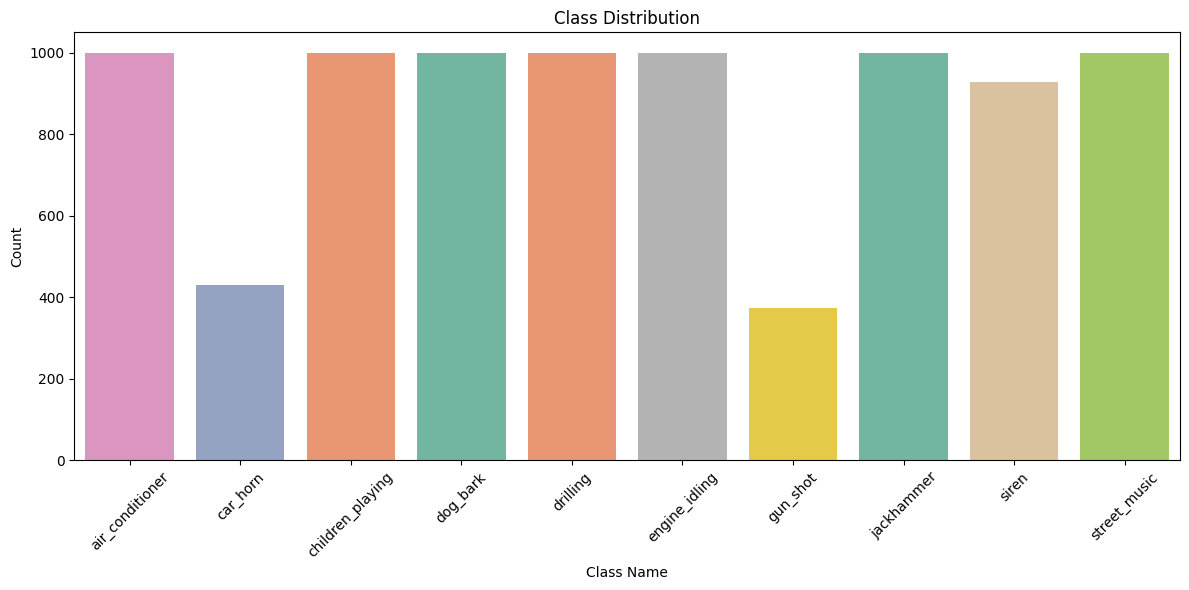

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

metadata["class_name"] = metadata["classID"].map(class_map)

plt.figure(figsize=(12,6))
sns.countplot(x=metadata["class_name"],hue="class_name",data=metadata, order=list(class_map.values()),palette="Set2")
plt.title("Class Distribution")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


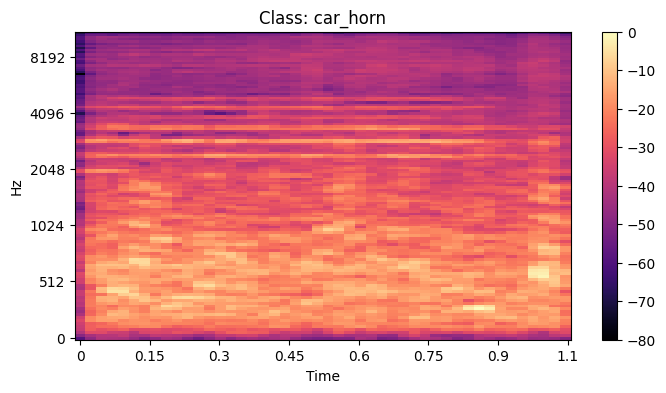

In [12]:
def show_example(idx):
    fp = metadata.loc[idx, "file_path"]
    audio, sr = librosa.load(fp)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr,n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(8,4))
    librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
    plt.title(f"Class: {metadata.loc[idx,'class']}")
    plt.colorbar()
    plt.show()

show_example(10)


###PCA Visualizaztion on Extracted Features

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


###Feature Extraction(Mel-Spectrogram for CNN)

In [19]:
def extract_mel_spectrogram(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)

        audio = librosa.effects.time_stretch(audio, rate=0.5)

        audio = audio[:3*sr]
        audio = librosa.util.fix_length(audio, size=3*sr)

        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        fixed_frames = 128  # choose consistent time dimension
        if mel_db.shape[1] < fixed_frames:
            mel_db = librosa.util.pad_center(data=mel_db, size= fixed_frames, axis=1)
        else:
            mel_db = mel_db[:, :fixed_frames]

        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


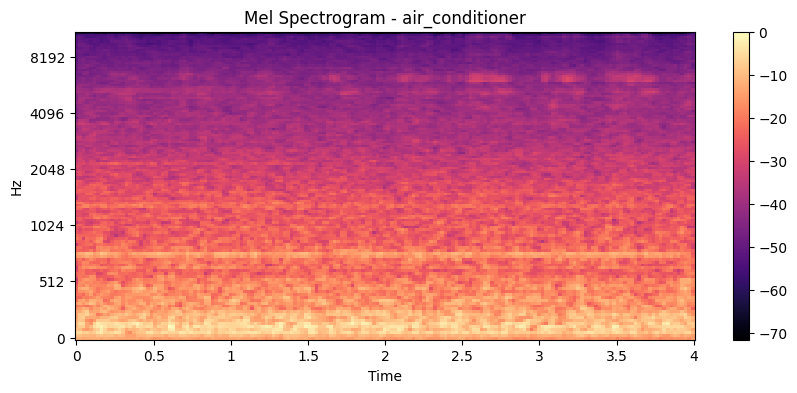

In [20]:
import random
idx = random.randint(0, len(metadata)-1)
file = metadata.loc[idx, "file_path"]
audio, sr = librosa.load(file)

mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
plt.title(f"Mel Spectrogram - {metadata.loc[idx,'class_name']}")
plt.colorbar()
plt.show()


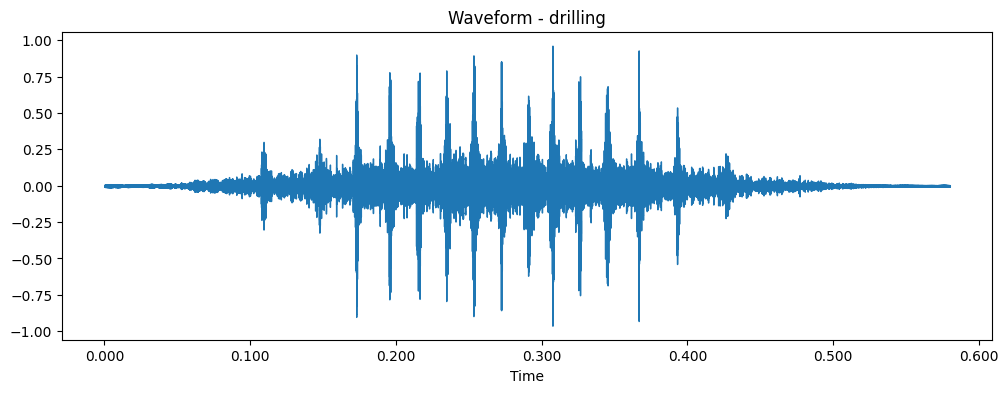

In [21]:
import random
import librosa.display

idx = random.randint(0, len(metadata)-1)
file = metadata.loc[idx, "file_path"]
audio, sr = librosa.load(file)

plt.figure(figsize=(12,4))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform - {metadata.loc[idx,'class_name']}")
plt.show()


###Train/Val/Test Split

In [22]:
from tqdm import tqdm
X = []
y = []


for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    mel = extract_mel_spectrogram(row['file_path'])
    if mel is not None:
        X.append(mel)
        y.append(row['classID'])


100%|██████████| 8732/8732 [51:15<00:00,  2.84it/s]


In [23]:
X = np.array(X)
y = np.array(y)


X = X[..., np.newaxis]


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [26]:
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (5588, 128, 128, 1)
Val: (1397, 128, 128, 1)
Test: (1747, 128, 128, 1)


##CNN Training

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (X.shape[1], X.shape[2], 1)
num_classes = len(np.unique(y))

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,290 (16.36 MB)

 Trainable params: 4,288,842 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [28]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32
)


Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.1986 - loss: 5.0268 - val_accuracy: 0.2470 - val_loss: 2.2017
Epoch 2/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.2470 - loss: 2.0773 - val_accuracy: 0.3644 - val_loss: 2.0522
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.2889 - loss: 1.9585 - val_accuracy: 0.3228 - val_loss: 1.8735
Epoch 4/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.3286 - loss: 1.7946 - val_accuracy: 0.4424 - val_loss: 1.5678
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.3577 - loss: 1.7158 - val_accuracy: 0.1174 - val_loss: 30.0833
Epoch 6/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.3735 - loss: 1.6794 - val_accuracy: 0.2427 - val_loss: 2.5966
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.4047 - loss: 1.6269 - val_accuracy: 0.4238 - val_loss: 1.5809
Epoch 8/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.4408 - loss: 1.4673 - val_acc

##Model Evaluation

In [29]:
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step - accuracy: 0.6291 - loss: 1.7520
Test accuracy: 0.636519730091095


###Accuracy,Precision,Recall,F1

In [31]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))


55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 505ms/step
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       200
           1       0.61      0.78      0.68        86
           2       0.39      0.33      0.36       200
           3       0.85      0.56      0.67       200
           4       0.89      0.67      0.77       200
           5       0.91      0.48      0.63       200
           6       0.85      0.91      0.88        75
           7       0.79      0.90      0.84       200
           8       0.81      0.70      0.76       186
           9       0.34      0.74      0.47       200

    accuracy                           0.64      1747
   macro avg       0.71      0.66      0.66      1747
weighted avg       0.70      0.64      0.65      1747



###Confusion Mattrix

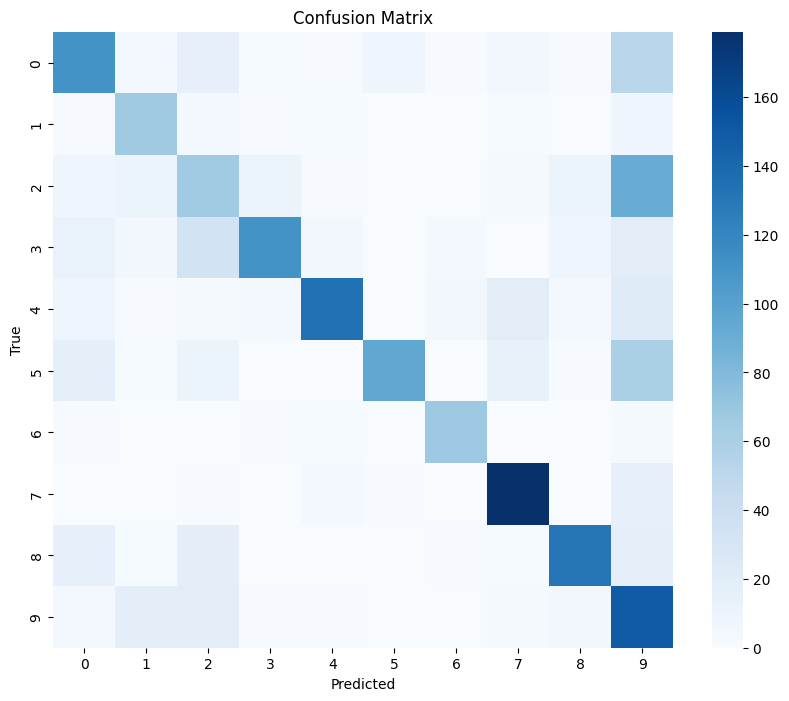

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
